# TODO

- Visualization
    - Color bar 
    - Line graph
- from, to point 정의 (Right)

- Point, Point가 점유하는 공간

- sulcus 추가
- hemisphere 동시 표현
- 양쪽으로 펼치기

# Common Libraries

In [1]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
import json

from glob import glob
from nilearn.plotting import view_img
from scipy.stats import ttest_1samp
from scipy.spatial import KDTree
from nilearn.plotting import plot_surf_roi
from collections import Counter
from copy import copy
from cv2 import minAreaRect, boxPoints, pointPolygonTest
from scipy.stats import sem
import seaborn as sns
from scipy.stats import ttest_1samp

# Custom Libraries

In [2]:
import sys

sys.path.append("/home/seojin")
sys.path.append("/home/seojin/Seojin_commonTool/Module")
import surfAnalysisPy as surf
from surface_analysis import vol_to_surf, surface_cross_section
from sj_matplotlib import draw_ticks, draw_spine, draw_label

# Params

In [3]:
surf_hemisphere = "R"
surf_resolution = 32

# Nifti image paths
volume_data_dir_path = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/Group/rsa/rdm/set/WholeSet/base_seqOnly/None/pattern_separation"
volume_data_paths = sorted(glob(volume_data_dir_path + "/*crossnobis*"))

# ROI
atlas = "Brodmann"

# For cross-section analysis (virtual strip)
from_point = None # x_start, y_start
to_point = None # x_end, y_end
if surf_hemisphere == "L":
    from_point = np.array([-24, 111])  
    to_point = np.array([81, 47])    

    # Dierdrichsen
    # from_point  = np.array([-43, 86])
    # to_point = np.array([87, 58]) 
else:
    from_point = np.array([23, 80])
    to_point = np.array([-75, 22]) 

    # Dierdrichsen
    # from_point  = np.array([-87, 43 - 10])
    # to_point = np.array([43, 75 - 10])
    
width = 20
cross_section_n_sampling = 30 # int(np.sqrt(np.sum((from_point - to_point) ** 2)))

if surf_hemisphere == "L":
    patten_separation_threshold = 0.0007
else:
    patten_separation_threshold = 0.0007


# Constants

In [4]:
surf_dir_path = f"/mnt/sda2/Common_dir/Atlas/Surface/fs_LR_{surf_resolution}"

# Template
pial_surf_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.pial.surf.gii")
white_surf_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.white.surf.gii")
template_surface_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.flat.surf.gii")
inflated_brain_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.inflated.surf.gii")
shape_gii_path = os.path.join(surf_dir_path, f"fs_LR.32k.{surf_hemisphere}.shape.gii")

# Sulcus
sulcus_path = os.path.join(surf_dir_path, "borders", f"{surf_hemisphere}_sulcus.json")
with open(sulcus_path, "r") as file:
    marking_data_info = json.load(file)

# ROI
roi_label_path = os.path.join(surf_dir_path, atlas, f"{surf_hemisphere}_rois.npy")
roi_labels = np.load(roi_label_path)

# Functions

In [5]:
def gaussian_weighted_smoothing(coords, values, sigma=1.0):
    """
    Apply Gaussian smoothing to scattered data without using a grid.
    
    Args:
    - coords: (N, 2) array of x, y coordinates.
    - values: (N,) array of corresponding values.
    - sigma: Standard deviation for Gaussian weighting.
    
    Returns:
    - smoothed_values: Smoothed values at each original coordinate.
    """
    tree = KDTree(coords)
    smoothed_values = np.zeros_like(values)
    for i, point in enumerate(coords):
        distances, indices = tree.query(point, k=50)  # Consider 50 nearest neighbors
        weights = np.exp(-distances**2 / (2 * sigma**2))
        smoothed_values[i] = np.sum(values[indices] * weights) / np.sum(weights)
    return smoothed_values

# Volume to Surface

In [6]:
surface_datas = []
for path in volume_data_paths:
    surface_data = vol_to_surf(volume_data_path = path,
                               pial_surf_path = pial_surf_path,
                               white_surf_path = white_surf_path)
    surface_datas.append(surface_data)
surface_datas = np.array(surface_datas).T

# Cross section analysis

In [8]:
template_surface_path

'/mnt/sda2/Common_dir/Atlas/Surface/fs_LR_32/fs_LR.32k.R.flat.surf.gii'

In [7]:
cross_section_result_info = surface_cross_section(template_surface_path = template_surface_path, 
                                                  surface_data = surface_datas, 
                                                  from_point = from_point, 
                                                  to_point = to_point, 
                                                  width = width,
                                                  n_sampling = cross_section_n_sampling)

In [8]:
sampling_datas = cross_section_result_info["sampling_datas"]
virtual_stip_mask = cross_section_result_info["virtual_stip_mask"]
sampling_center_coords = cross_section_result_info["sampling_center_coords"]
sampling_coverages = cross_section_result_info["sampling_coverages"]

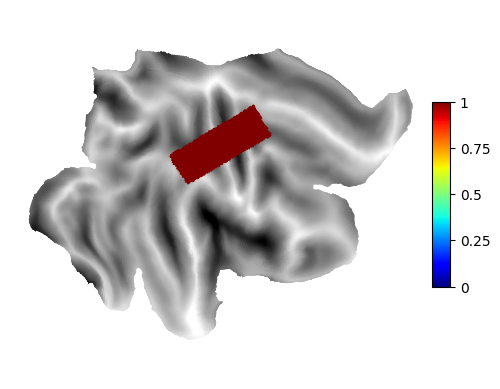

In [10]:
strip_ax = surf.plot.plotmap(data = virtual_stip_mask, 
                             surf = f"fs{surf_resolution}k_R", 
                             colorbar = True, 
                             threshold = 0.0005)

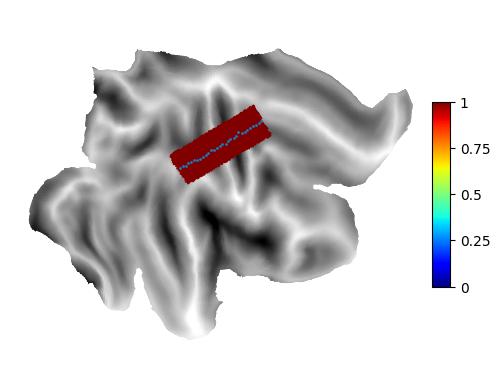

In [203]:
strip_ax.scatter(sampling_center_coords[:, 0], sampling_center_coords[:, 1], s = 1)
strip_ax.get_figure()

In [204]:
sampling_coverages_sum = np.array([np.where(e != 0, i/10, 0) for i, e in enumerate(sampling_coverages)]).T
sampling_coverages_sum = np.sum(sampling_coverages_sum, axis = 1)

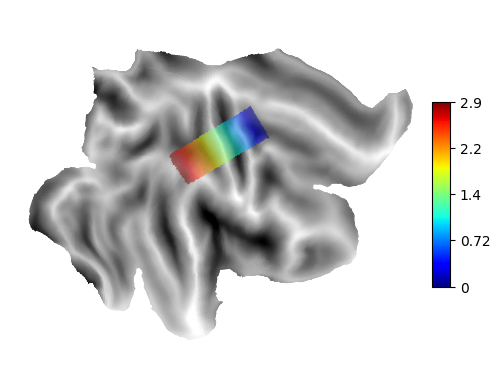

In [205]:
sampling_coverage_ax = surf.plot.plotmap(data = sampling_coverages_sum, 
                                         surf = f"fs{surf_resolution}k_{surf_hemisphere}", 
                                         colorbar = True, 
                                         threshold = 0.0001,
                                         alpha = 0.5)

# Non-smoothing

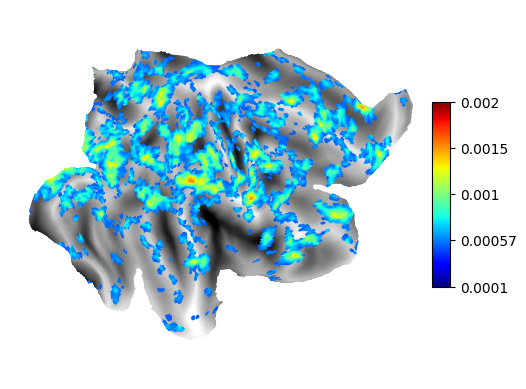

In [206]:
slightly_small_value = 0.0001

ax = surf.plot.plotmap(data = np.mean(surface_datas, axis = 1), 
                       surf = f"fs{surf_resolution}k_{surf_hemisphere}", 
                       colorbar = True, 
                       threshold = 0.0005,
                       cscale = [slightly_small_value, 0.002])

# Smoothing

In [207]:
# Template vertex coordinates
temploate_surface_data = nb.load(template_surface_path)
vertex_locs = temploate_surface_data.darrays[0].data[:, :2]

# Data
mean_data = np.mean(surface_datas, axis = 1)
smoothed_data = gaussian_weighted_smoothing(coords = vertex_locs, 
                                            values = mean_data, 
                                            sigma = 2.0)

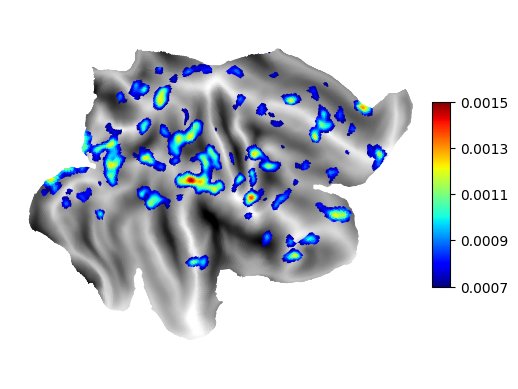

In [208]:
slightly_small_value = 0.0001

surf_stat_ax = surf.plot.plotmap(data = smoothed_data, 
                                 surf = f"fs{surf_resolution}k_{surf_hemisphere}", 
                                 colorbar = True, 
                                 threshold = patten_separation_threshold,
                                 cscale = [patten_separation_threshold, np.max(smoothed_data)])

# Filter data only including in rectangle (from ~ to)

In [209]:
rect_vertexes = vertex_locs[np.where(virtual_stip_mask == 1, True, False)]
min_rect_x, max_rect_x = np.min(rect_vertexes[:, 0]), np.max(rect_vertexes[:, 0])
min_rect_y, max_rect_y = np.min(rect_vertexes[:, 1]), np.max(rect_vertexes[:, 1])
within_x = (vertex_locs[:, 0] >= min_rect_x) & (vertex_locs[:, 0] <= max_rect_x)
within_y = (vertex_locs[:, 1] >= min_rect_y) & (vertex_locs[:, 1] <= max_rect_y)
is_within_rectangle = np.logical_and(within_x, within_y)

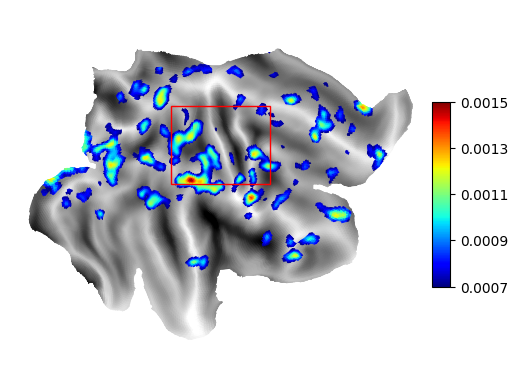

In [210]:
rect = Rectangle((min_rect_x, min_rect_y), max_rect_x - min_rect_x, max_rect_y - min_rect_y, linewidth=1, edgecolor='r', facecolor='none')
ax = surf.plot.plotmap(data = smoothed_data, 
                       surf = f"fs{surf_resolution}k_{surf_hemisphere}", 
                       colorbar = True, 
                       threshold = patten_separation_threshold,
                       cscale = [patten_separation_threshold, np.max(smoothed_data)])
ax.add_patch(rect)

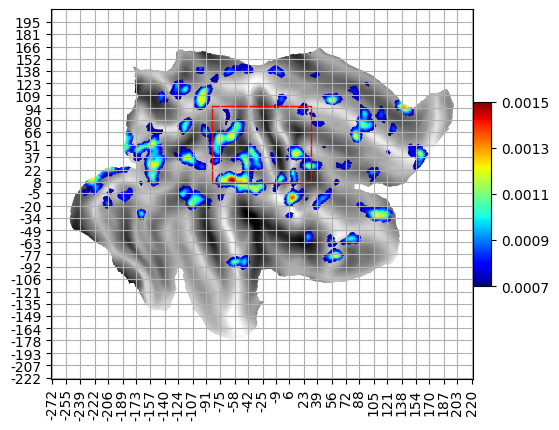

In [211]:
ax.grid(True)
ax.axis("on")
x_min, x_max = int(ax.get_xlim()[0]), int(ax.get_xlim()[1])
y_min, y_max = int(ax.get_ylim()[0]), int(ax.get_ylim()[1])

x_count = 30
y_count = 30
x_interval = (x_max - x_min) / x_count
y_interval = (y_max - y_min) / y_count
ax.set_xticks(np.arange(x_min, x_max, x_interval).astype(int))
ax.set_xticklabels(np.arange(x_min, x_max, x_interval).astype(int), rotation = 90)

ax.set_yticks(np.arange(y_min, y_max, y_interval).astype(int))
ax.set_yticklabels(np.arange(y_min, y_max, y_interval).astype(int), rotation = 0)

ax.get_figure()

# Visualizaion - sampling coverages

In [212]:
rect = Rectangle((min_rect_x, min_rect_y), max_rect_x - min_rect_x, max_rect_y - min_rect_y, linewidth=1, edgecolor='r', facecolor='none')
sampling_coverage_ax.add_patch(rect)

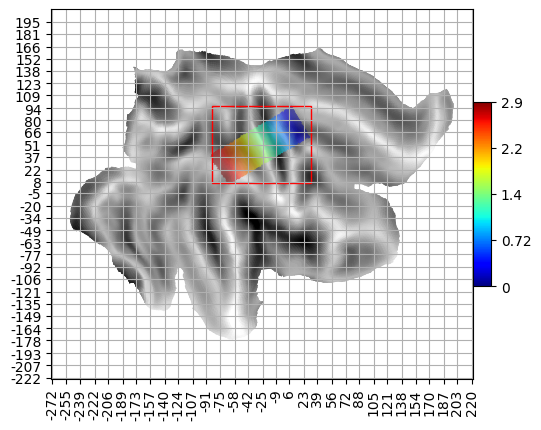

In [213]:
sampling_coverage_ax.get_figure()
sampling_coverage_ax.grid(True)
sampling_coverage_ax.axis("on")
x_min, x_max = int(sampling_coverage_ax.get_xlim()[0]), int(sampling_coverage_ax.get_xlim()[1])
y_min, y_max = int(sampling_coverage_ax.get_ylim()[0]), int(sampling_coverage_ax.get_ylim()[1])

x_count = 30
y_count = 30
x_interval = (x_max - x_min) / x_count
y_interval = (y_max - y_min) / y_count
sampling_coverage_ax.set_xticks(np.arange(x_min, x_max, x_interval).astype(int))
sampling_coverage_ax.set_xticklabels(np.arange(x_min, x_max, x_interval).astype(int), rotation = 90)

sampling_coverage_ax.set_yticks(np.arange(y_min, y_max, y_interval).astype(int))
sampling_coverage_ax.set_yticklabels(np.arange(y_min, y_max, y_interval).astype(int), rotation = 0)

sampling_coverage_ax.get_figure()

# Sulcus

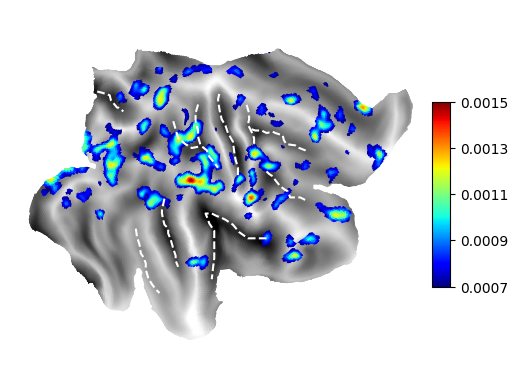

In [214]:
copy_ax = copy(surf_stat_ax)
for sulcus_name in marking_data_info:
    copy_ax.plot(np.array(marking_data_info[sulcus_name])[:, 0], 
                 np.array(marking_data_info[sulcus_name])[:, 1], 
                 color = "white",  
                 linestyle='dashed')
copy_ax.get_figure()

In [215]:
having_sulcus_prob_info = {}
for sulcus_name in marking_data_info:
    sulcus_pts = marking_data_info[sulcus_name]

    having_sulcus_probs = []
    for coverage in sampling_coverages:
        coverage_vertexes = vertex_locs[np.where(coverage == 0, False, True)]
        rect = minAreaRect(coverage_vertexes)
        box = boxPoints(rect)
    
        is_having_sulcus = np.array([pointPolygonTest(box, pts, False) for pts in sulcus_pts])
        having_sulcus_prob = np.sum(is_having_sulcus == 1) / len(sulcus_pts)
        having_sulcus_probs.append(having_sulcus_prob)
    having_sulcus_prob_info[sulcus_name] = np.array(having_sulcus_probs)

In [216]:
is_first_index = False

sulcus_names = ["" for _ in range(cross_section_n_sampling)]
for sulcus_name in having_sulcus_prob_info:

    if is_first_index:
        searches = np.where(having_sulcus_prob_info[sulcus_name] != 0)[0]

        if len(searches) > 0:
            first_index = searches[0]
            sulcus_names[first_index] = sulcus_name
    else:
        max_prob = max(having_sulcus_prob_info[sulcus_name])
    
        if max_prob != 0:
            max_prob_index = np.argmax(having_sulcus_prob_info[sulcus_name])
            sulcus_names[max_prob_index] = sulcus_name
sulcus_names = np.array(sulcus_names)

In [217]:
sulcus_names[0] = ""

# ROIs

In [218]:
sampling_coverage_roi_probs = []
for sampling_i in range(cross_section_n_sampling):
    is_covering = sampling_coverages[sampling_i] == 1
    cover_labels = roi_labels[np.where(is_covering, True, False)]

    n_convering = np.sum(is_covering)

    counter = Counter(cover_labels)

    rois = np.array(list(counter.keys()))
    probs = np.array(list(counter.values())) / n_convering
    
    # Decending order
    sorted_prob_indexes = np.argsort(probs)[::-1]
    
    prob_info = {}
    for prob_index in sorted_prob_indexes:
        prob_info[rois[prob_index]] = probs[prob_index]
    
    sampling_coverage_roi_probs.append(prob_info)

In [219]:
rois = [max(roi_prob, key = roi_prob.get) for roi_prob in sampling_coverage_roi_probs]
rois = [roi.replace("|", "") for roi in rois]
rois = np.array([roi.replace(f"{surf_hemisphere}_", "") for roi in rois])
rois[np.where(rois == "2")[0]] = "1+2+3"
rois = np.where(rois == "1+2+3", "3+1+2", rois)
rois = np.array([roi.replace("+", ", ") for roi in rois])

In [220]:
p_threshold = 0.05

stat_result = ttest_1samp(sampling_datas, popmean = 0, axis = 1)
significant_indexes = np.where(stat_result.pvalue < p_threshold)[0]

In [221]:
def sulcus_abbreviation_name(sulcus_name):
    if sulcus_name == "Precentral sulcus":
        return "Pre-CS"
    elif sulcus_name == "Central sulcus":
        return "CS"
    elif sulcus_name == "Post central sulcus":
        return "Post-CS"
    elif sulcus_name == "Intra parietal sulcus":
        return "IPS"

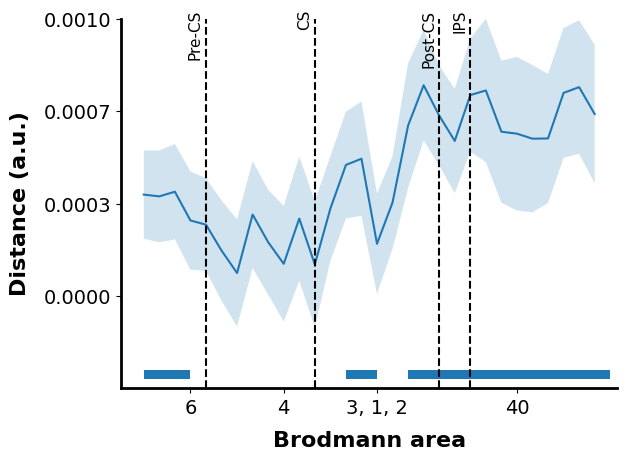

In [222]:
fig, axis = plt.subplots(1)

xs = np.arange(cross_section_n_sampling).astype(str)
indexes = np.where(sulcus_names != "")[0]
sulcuses = sulcus_names[indexes]

# Plot
mean_values = np.mean(sampling_datas, axis = 1)
axis.plot(xs, mean_values)

errors = sem(sampling_datas, axis = 1)
axis.fill_between(xs,
                  mean_values - errors, mean_values + errors, 
                  alpha = 0.2)

"""
for i, data in enumerate(sampling_datas):
    sns.stripplot(x=i, y=data, alpha=0.2, color = "black")
"""

# Set ticks
min_ = 0
max_ = np.max(mean_values + errors)

n_div = 3 
interval = (min_ + max_) / n_div
y_data = np.arange(min_, max_ + interval, interval)

"""
# Draw roi
unique_rois = np.unique(rois)
roi_start_indexes = np.array(sorted([list(rois).index(roi) for roi in unique_rois])) # Select start index of ROI
roi_start_indexes = roi_start_indexes[1:]
for roi_start_i in roi_start_indexes:
    axis.axvline(x = roi_start_i, color = "black", linestyle = "dashed")
"""

# Draw spines
draw_spine(axis)

# Draw labels
label_info = {}
label_info["x_label"] = "Brodmann area"
label_info["y_label"] = "Distance (a.u.)"
draw_label(axis, label_info)
plt.ylim(min_ - interval, max_)

# Sulcus
sulcus_indexes = np.where(sulcus_names != "")[0]
for sulcus_i in sulcus_indexes:
    sulcus_name = sulcus_names[sulcus_i]
    
    axis.axvline(x = sulcus_i, color = "black", linestyle = "dashed")
    axis.text(x = sulcus_i - 0.2, 
              y = max_ + (interval/10), 
              s = sulcus_abbreviation_name(sulcus_name),  
              va = "top", 
              ha = "right",
              size = 11,
              rotation = 90)

# Show significant areas
rect_height = interval / 10
for sig_i in significant_indexes:
    axis.add_patch(Rectangle(xy = (sig_i, min_ - interval + rect_height), width = 1, height = rect_height))

tick_info = {}
tick_info["x_data"] = np.arange(len(rois))
tick_info["x_names"] = rois
tick_info["x_tick_rotation"] = 0
tick_info["y_data"] = y_data
tick_info["y_names"] = y_data
draw_ticks(axis, tick_info)

y_tick_round = 4
axis.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.{y_tick_round}f}"))

# Surf ROI

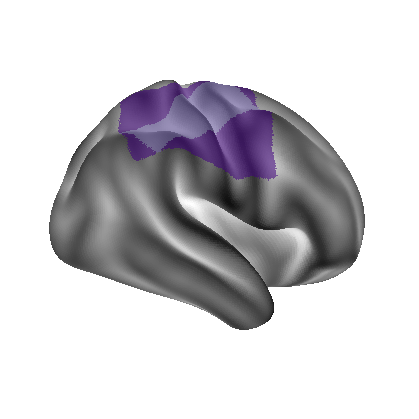

In [162]:
fig = plot_surf_roi(surf_mesh = inflated_brain_path,
                    roi_map = np.where(virtual_stip_mask, 0.7, np.where(is_within_rectangle, 1, 0)),
                    bg_map = shape_gii_path,
                    hemi = "left" if surf_hemisphere == "L" else "right",
                    cmap='Purples',
                    alpha = 2, 
                    vmax = 1, # 1.4, 3
                    bg_on_data = True,
                    darkness = 1.0
)

- 